In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
## Determine how to calculate the number of frames and loop over them
data_dir = "/home/nate/Documents/simplerecon/tello/tello-fusion-images-2023-05-13-12-18-27"
depth_dir = "/".join(data_dir.split("/")[:-1]) + "/depths-from-" + data_dir.split("/")[-1]

print(depth_dir)

# Number of files ending with .color.jpg in data_dir
num_imgs = len([name for name in os.listdir(data_dir) if name.endswith(".color.jpg")])
print("Number of images: ", num_imgs)

# Number of files ending with .color.jpg in data_dir
num_poses = len([name for name in os.listdir(data_dir) if name.endswith(".pose.txt")])
print("Number of poses: ", num_poses)

# Assert that num_poses = num_imgs
assert num_poses == num_imgs, "Number of images and poses must be the same."


# Specify the number of source images to use
num_src_imgs = 7 #n images to use for the n+1st image's depth estimate

# Specify indices for the source images
src_img_inds = range(0,num_src_imgs) # 1st to nth image as source images

# for cur_img_ind from num_src_imgs to num_imgs:
for cur_img_ind in range(num_src_imgs, num_imgs): # check this
    src_img_inds = range(cur_img_ind-num_src_imgs,cur_img_ind) # look n images back from current image

/home/nate/Documents/simplerecon/tello/depths-from-tello-fusion-images-2023-05-13-12-18-27
Number of images:  193
Number of poses:  193


['depth.millimeters.frame-000161.npy', 'depth.millimeters.frame-000142.npy', 'depth.millimeters.frame-000107.npy', 'depth.millimeters.frame-000111.npy', 'depth.millimeters.frame-000010.npy', 'depth.millimeters.frame-000124.npy', 'depth.millimeters.frame-000089.npy', 'depth.millimeters.frame-000030.npy', 'depth.millimeters.frame-000037.npy', 'depth.millimeters.frame-000073.npy', 'depth.millimeters.frame-000183.npy', 'depth.millimeters.frame-000180.npy', 'depth.millimeters.frame-000072.npy', 'depth.millimeters.frame-000109.npy', 'depth.millimeters.frame-000094.npy', 'depth.millimeters.frame-000045.npy', 'depth.millimeters.frame-000020.npy', 'depth.millimeters.frame-000167.npy', 'depth.millimeters.frame-000023.npy', 'depth.millimeters.frame-000063.npy', 'depth.millimeters.frame-000099.npy', 'depth.millimeters.frame-000187.npy', 'depth.millimeters.frame-000054.npy', 'depth.millimeters.frame-000060.npy', 'depth.millimeters.frame-000055.npy', 'depth.millimeters.frame-000095.npy', 'depth.mill

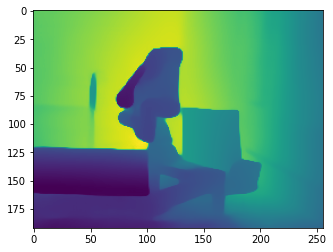

In [33]:
# Convert a directory of numpy depths into frames
depth_img_dir = "/".join(data_dir.split("/")[:-1]) + "/depth-imgs-from-" + data_dir.split("/")[-1]
if not os.path.exists(depth_img_dir):
    os.makedirs(depth_img_dir)

# print the contents of depth_dir
print(os.listdir(depth_dir))

# for each file in depth_dir:
for file in os.listdir(depth_dir):
    print(file)
    # load depth
    depth = np.load(depth_dir + "/" + file) # numpy array
    # save to jpg
    plt.imshow(depth); plt.savefig(depth_img_dir + "/" + file + ".jpg")

In [1]:
import os
import pickle
from pathlib import Path

import numpy as np
import pyrender
import torch
import torch.nn.functional as F
import trimesh
from PIL import Image
from tqdm import tqdm

from experiment_modules.depth_model import DepthModel
import options
from tools import fusers_helper
from tools.mesh_renderer import (DEFAULT_CAM_FRUSTUM_MATERIAL,
                                 DEFAULT_MESH_MATERIAL, Renderer,
                                 SmoothBirdsEyeCamera, camera_marker,
                                 create_light_array, get_image_box,
                                 transform_trimesh)
from utils.dataset_utils import get_dataset
from utils.generic_utils import to_gpu
from utils.visualization_utils import colormap_image, save_viz_video_frames

import modules.cost_volume as cost_volume

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# get an instance of options and load it with config file(s) and cli args.
option_handler = options.OptionsHandler()
option_handler.parse_and_merge_options()
option_handler.pretty_print_options()
print("\n")
opts = option_handler.options

# if no GPUs are available for us then, use the 32 bit on CPU
if opts.gpus == 0:
    print("Setting precision to 32 bits since --gpus is set to 0.")
    opts.precision = 32

usage: ipykernel_launcher.py [-h] [--config_file CONFIG_FILE]
                             [--data_config_file DATA_CONFIG_FILE]
                             [--random_seed RANDOM_SEED] [--name NAME]
                             [--log_dir LOG_DIR] [--notes NOTES]
                             [--log_interval LOG_INTERVAL]
                             [--val_interval VAL_INTERVAL]
                             [--val_batches VAL_BATCHES] [--dataset DATASET]
                             [--dataset_path DATASET_PATH]
                             [--num_workers NUM_WORKERS]
                             [--tuple_info_file_location TUPLE_INFO_FILE_LOCATION]
                             [--mv_tuple_file_suffix MV_TUPLE_FILE_SUFFIX]
                             [--frame_tuple_type FRAME_TUPLE_TYPE]
                             [--model_num_views MODEL_NUM_VIEWS]
                             [--num_images_in_tuple NUM_IMAGES_IN_TUPLE]
                             [--dataset_scan_split_file DATAS

SystemExit: 2